# IOAI2025 On-Site Stage: Pixel Efficiency Challenge

### Note: Please "join" the competition first. Then, you can mount the dataset to the GPU. Otherwise, the notebook may encounter an error because it cannot access the dataset until you have joined the competition.

## 1. Problem Description
You are a student in wildlife biology, working on a groundbreaking research project at the Starr Park Research Center. Your team has deployed thousands of camera traps across remote wilderness areas to monitor endangered species populations. However, the satellite internet connections in these remote locations have extremely limited bandwidth. Your job is to write code that identifies the most critical pixels in each wildlife photograph so that only the essential visual information needs to be transmitted back to headquarters.

## 2. Dataset

The dataset consists of a training set and a test set. Datasets are stored under the same directory as the notebook and are loaded using `load_from_disk`.

In the dataset there are the following fields:

- `image`: the image in PIL format
- `name`: the animal species label
- `idx`: unique identifiers used to track the records.

1. **Training Set (`train_dataset` folder)**:

    The training set is used for training your models/ doing experimentations on and can be accessed and downloaded directly during the competition.

2. **Test Set (`test_dataset` folder)**: 
    - These are similar to the training set format but do not contain the label column.

    The testing set is used to calculate the Leaderboard A score and the Leaderboard B score and is not directly accessible during the competition. See part 4 to understand more about how the scoring is done with this set.

## 3. Task
You are given a dataset of animal photographs and a CLIP model that can do a zero-shot classification of animal species. To conserve bandwidth, you need to retain at most *6.25%* of the` pixels of each image, while keeping classification accuracy as high as possible.

More specifically, your task is to return rectangle masks for each image. All images are of size (224, 224). Each mask is defined by two coordinate tuples: one for the top-left corner and one for the bottom-right corner of the rectangle.

**Coordinate Convention:**
- Top-left corner coordinates are **inclusive** (the pixel at this position IS included in the mask)
- Bottom-right corner coordinates are **exclusive** (the pixel at this position is NOT included in the mask)

For example, if you specify coordinates `((10, 20), (15, 25))`, the mask will cover pixels from row 10 to 14 (inclusive) and column 20 to 24 (inclusive), for a total area of 25 pixels.

As an illustration, if an image would be 3x3 and we wanted to keep only the top-right part using coordinates `((0, 2), (1, 3))`, the resulting binary mask would be:

```
[[0, 0, 1],
 [0, 0, 0],
 [0, 0, 0]]
```

Images would be masked using the mask you created, with masked areas replaced with RGB(0, 0, 0) values. The masked image will be then passed through the CLIP model during evaluation, and your task is to keep the classification accuracy of the CLIP model on these masked images as high as possible. **An additional `other` class would be added into the classes for classification** to ensure that your masked image retains actual useful information for the researchers back at Starr Park Headquarters.

You need to work only with the provided CLIP model and dataset. As a reminder, CLIP generates representations for both text and image, and it can compute a similarity score between them. So if you have ten animal classes, CLIP can look at the provided image and decide which text (class) is closest to the image. As a tip, you can use the python `help()` function to view the documentation for any library components.

In [11]:
import random
import numpy as np
import torch

seed = 42

random.seed(seed)                  # Python built-in random
np.random.seed(seed)               # NumPy
torch.manual_seed(seed)            # PyTorch (CPU)
torch.cuda.manual_seed(seed)       # PyTorch (single GPU)
torch.cuda.manual_seed_all(seed)   # PyTorch (all GPUs)

# Ensures deterministic behavior
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [12]:
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
from PIL import Image
from tqdm import tqdm
import glob
import json
import math
import torch
import matplotlib.pyplot as plt
from datasets import load_dataset, load_from_disk
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from tqdm.auto import tqdm 

TRAIN_PATH = "./data/"
# The training set is deployed automatically in the testing machine. 
# You notebook can access the TRAIN_PATH even if you do not mount it along with notebook.

MODEL_PATH = "openai/clip-vit-large-patch14"
# The clip model is deployed automatically in the testing machine. 
# You notebook can access the MODEL_PATH even if you do not mount it along with notebook.

DATASET_PATH = TRAIN_PATH
SPLIT = "train"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BACKGROUND_CLASS = "other" # Class used to catch masked images that have no useful information, preventing completely off masks from "guessing" the answer from the 10 classes

# Image and Masking Configuration
HEIGHT = 224
WIDTH = 224
RETAIN_RATIO = 0.0625  # Retain 6.25% of pixels
MEAN_COLOR = (0, 0, 0)  # RGB mean values for masked out areas


In [13]:
# Load the dataset
print("Loading dataset...")
dataset_whole = load_from_disk(DATASET_PATH)
dataset = dataset_whole[SPLIT]

# Print first item to check available fields
print("\nFirst item keys:")
print(dataset_whole[SPLIT][0].keys())

# Show basic dataset statistics without converting fields yet
print(f"\nDataset loaded successfully!")
print(f"Total samples: {len(dataset)}")

print(f"\nSample item structure:")
sample_item = dataset[0]
print(f"  Keys: {list(sample_item.keys())}")
print(f"  Image type: {type(sample_item['image'])}")
print(f"  Image size: {sample_item['image'].size}")
print(f"  Index: {sample_item['idx']}")



Loading dataset...

First item keys:
dict_keys(['name', 'image', 'idx'])

Dataset loaded successfully!
Total samples: 700

Sample item structure:
  Keys: ['name', 'image', 'idx']
  Image type: <class 'PIL.PngImagePlugin.PngImageFile'>
  Image size: (224, 224)
  Index: 5865e297-23d2-11e8-a6a3-ec086b02610b


Visualizing first 10 samples...


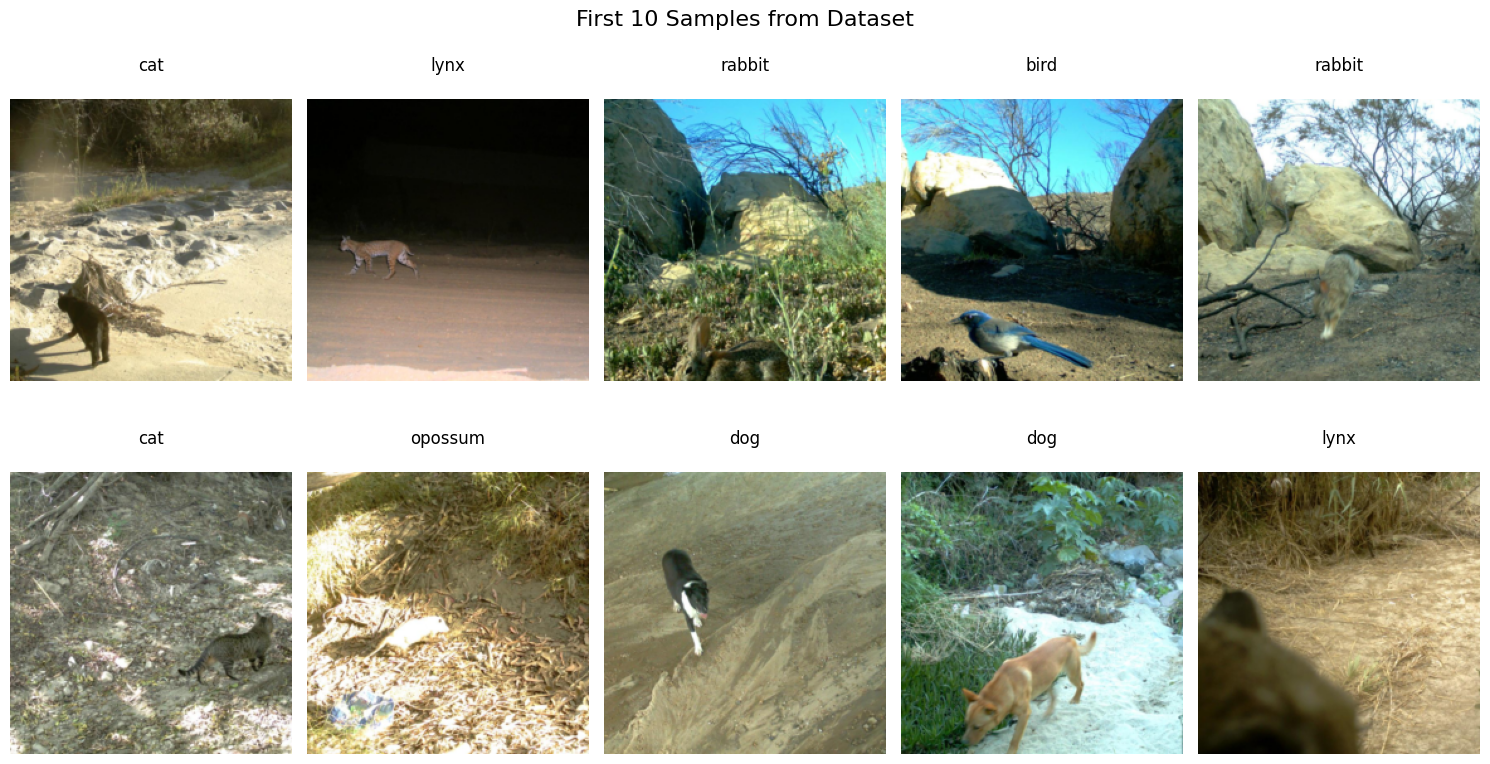

In [14]:
# Visualize first 10 samples
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
axes = axes.flatten()

print("Visualizing first 10 samples...")

for i in range(10):
    sample = dataset[i]
    image = sample['image']
    label = sample['name']
    
    axes[i].imshow(image)
    axes[i].set_title(f"{label}\n", fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('First 10 Samples from Dataset', fontsize=16, y=1.02)
plt.show()


## Model

In [15]:
print(f"Loading CLIP model and processor: {MODEL_PATH}...")
model = CLIPModel.from_pretrained(MODEL_PATH).to(DEVICE)
processor = CLIPProcessor.from_pretrained(MODEL_PATH)
print("Model and processor loaded successfully.")

Loading CLIP model and processor: openai/clip-vit-large-patch14...
Model and processor loaded successfully.


In [27]:
import torch
from PIL import Image
from typing import List, Union

def get_text_embeddings(texts: List[str]) -> torch.Tensor:
    # Process texts in batches
    inputs = processor(
        text=texts,
        return_tensors="pt",
        padding=True,
        truncation=True
    ).to(DEVICE)
    
    # Get embeddings
    with torch.no_grad():
        text_embeddings = model.get_text_features(**inputs)
    
    return text_embeddings

def get_image_embeddings(images: List[Image.Image]) -> torch.Tensor:
    # Process images in batches
    inputs = processor(
        images=images,
        return_tensors="pt"
    ).to(DEVICE)
    
    # Get embeddings
    with torch.no_grad():
        image_embeddings = model.get_image_features(**inputs)
    
    return image_embeddings

In [31]:
# Text embeddings
texts = ["a photo of a cat", "a photo of a dog"]
text_embeddings = get_text_embeddings(texts)

print(text_embeddings.shape)

# Image embeddings
images = [dataset[0]['image'],dataset[1]['image']]
image_embeddings = get_image_embeddings(images)
print(image_embeddings.shape)

torch.Size([2, 768])
torch.Size([2, 768])


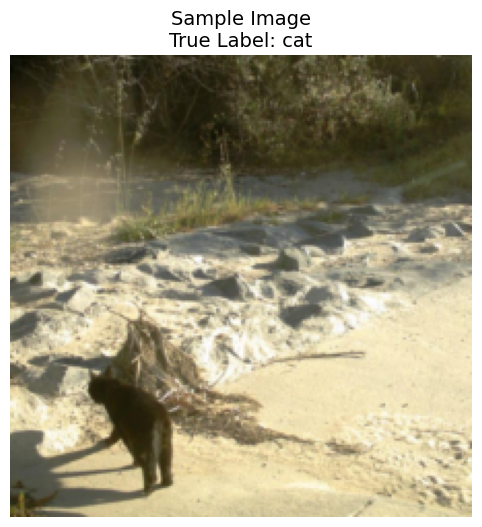

Predicted label: cat


In [16]:
image = dataset[0]['image']
# Visualize the image with its true label
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title(f"Sample Image\nTrue Label: {dataset[0]['name']}", fontsize=14)
plt.axis('off')
plt.show()


labels = sorted(list(set(dataset['name']))) + [BACKGROUND_CLASS]
text_inputs = processor(text=labels, return_tensors="pt", padding=True).to(DEVICE)
image_processed = processor(images=image, return_tensors="pt").to(DEVICE)
pixel_values = image_processed['pixel_values']
outputs_full = model(pixel_values=pixel_values, **text_inputs)
logits_full = outputs_full.logits_per_image  # Shape: (1, num_styles)
predicted_index_full = logits_full.argmax(dim=-1).item()

print(f"Predicted label: {labels[predicted_index_full]}")


In [17]:
def generate_center_crop_coordinates(image):
    """
    Generate coordinates for a center crop mask.
    
    Returns:
        tuple: ((top, left), (bottom, right)) coordinates for the crop
    """
    H, W = image.size
    total_px = H * W
    k = int(total_px * RETAIN_RATIO)
    
    # Calculate side length of the square crop
    side_length = int(np.sqrt(k))
    
    # Calculate center coordinates
    center_h, center_w = H // 2, W // 2
    
    # Calculate crop boundaries
    half_side = side_length // 2
    top = max(0, center_h - half_side)
    left = max(0, center_w - half_side)
    bottom = min(H, top + side_length)
    right = min(W, left + side_length)
    
    return ((top, left), (bottom, right))

def generate_mask_from_coordinates(image, coordinates):
    """
    Generate a binary mask from crop coordinates.
    
    Parameters:
        image: PIL Image
        coordinates: tuple of ((top, left), (bottom, right))
    
    Returns:
        numpy array: Binary mask with 1s in the crop area
    """
    H, W = image.size
    mask = np.zeros((H, W), dtype=np.int8)
    
    (top, left), (bottom, right) = coordinates
    mask[top:bottom, left:right] = 1
    
    return mask

In [18]:
def apply_mask_with_mean(image, mask, mean_rgb=MEAN_COLOR):
    """
    Apply arbitrary binary mask to image, replacing masked areas with mean values

    Parameters:
    - image: PIL Image (224x224)
    - mask: Binary numpy array or PIL Image (224x224) where 0 is the area to drop and 1 is the area to keep
    - mean_rgb: RGB mean values to use (default: from config)

    Returns: Modified PIL Image
    """
    # Convert images to numpy arrays
    img_array = np.array(image).copy()

    # Ensure mask is numpy array
    if isinstance(mask, Image.Image):
        mask_array = np.array(mask.convert('L')) > 127  # Convert to binary
    else:
        mask_array = mask > 0

    # Reshape mask for broadcasting with RGB
    mask_3d = np.stack([mask_array] * 3, axis=2)

    # Convert mean values to 0-255 range
    mean_values = np.array([int(m * 255) for m in mean_rgb])
    # Apply mask - replace areas where mask is 0 (drop) with mean values, keep areas where mask is 1
    img_array = np.where(mask_3d, img_array, mean_values.reshape(1, 1, 3))

    return Image.fromarray(img_array.astype(np.uint8))

In [81]:
LABELS = sorted(list(set(dataset['name'])))
TEXT_INPUTS = processor(text=labels, return_tensors="pt", padding=True).to(DEVICE)

In [113]:
import torch
import torch.nn.functional as F
from PIL import Image
from typing import Tuple

def find_best_mask_for_detected_animal(
    image: Image.Image,
    window_size = 56, 
    step = 56,
    batch_size=16,
    mean_rgb: Tuple[int, int, int] = MEAN_COLOR
) -> Tuple[Image.Image, float, str, Tuple[int, int, int, int]]:

    # Process the full image
    image_processed = processor(images=image, return_tensors="pt").to(DEVICE)
    pixel_values = image_processed['pixel_values']
    outputs_full = model(pixel_values=pixel_values, **TEXT_INPUTS)
    logits_full = outputs_full.logits_per_image
    predicted_index_full = logits_full.argmax(dim=-1).item()

    animal_to_detect = LABELS[predicted_index_full]
    
    # Get text embeddings for the detected animal
    text_embeddings = get_text_embeddings([animal_to_detect])  # Shape: (1, embedding_dim)
    text_embeddings = F.normalize(text_embeddings, p=2, dim=-1)
    
    best_similarity = -1.0
    best_coordinates = (0, 0), (0, 0)
    
    width, height = image.size

    # Initialize empty lists to store batch data
    batch_images = []
    batch_coordinates = []

    for y in range(0, height - window_size + 1, step):
        for x in range(0, width - window_size + 1, step):
            coordinates = ((x, y), (x + window_size, y + window_size))
            mask = generate_mask_from_coordinates(image, coordinates)
            masked_image = apply_mask_with_mean(image, mask, mean_rgb)
            
            # Add the masked image and coordinates to the batch lists
            batch_images.append(masked_image)
            batch_coordinates.append(coordinates)
            
            # Check if the batch is ready for processing
            if len(batch_images) == batch_size:
                # Get embeddings for the batch of masked images
                image_embeddings = get_image_embeddings(batch_images)
                image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)
                
                # Calculate similarities with text embeddings
                similarities = torch.matmul(image_embeddings, text_embeddings.T)
                max_similarities, max_indices = torch.max(similarities, dim=1)
                
                for sim, idx, coord in zip(max_similarities, max_indices, batch_coordinates):
                    current_similarity = sim.item()
                    if current_similarity > best_similarity:
                        best_similarity = current_similarity
                        best_coordinates = coord
                
                # Clear the batch lists for the next iteration
                batch_images = []
                batch_coordinates = []

    # Process any remaining images in the last batch
    if len(batch_images) > 0:
        image_embeddings = get_image_embeddings(batch_images)
        image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)
        
        similarities = torch.matmul(image_embeddings, text_embeddings.T)
        max_similarities, max_indices = torch.max(similarities, dim=1)
        
        for sim, idx, coord in zip(max_similarities, max_indices, batch_coordinates):
            current_similarity = sim.item()
            if current_similarity > best_similarity:
                best_similarity = current_similarity
                best_coordinates = coord
    
    return best_coordinates

In [106]:
coords = find_best_mask_for_detected_animal(
    dataset[0]['image'],
)

print(coords)

((168, 112), (224, 168))


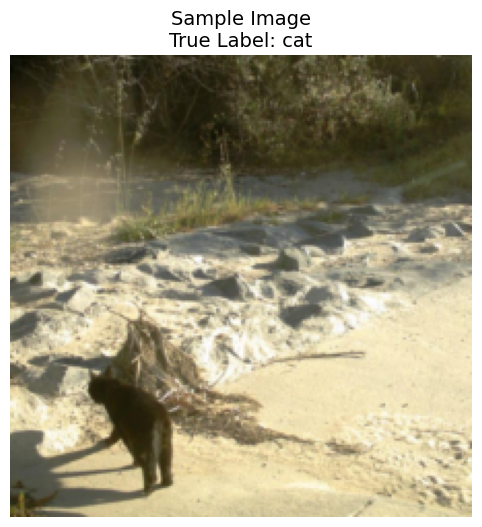

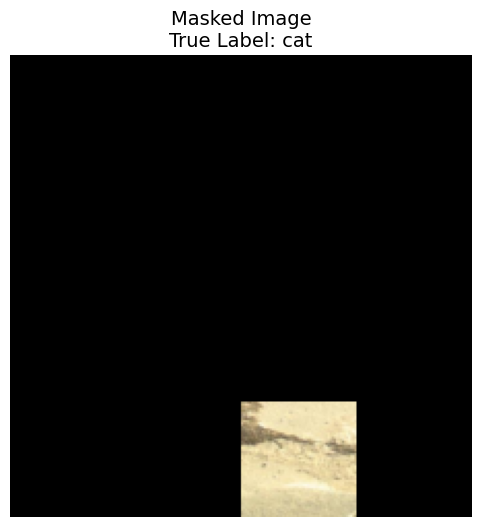

Predicted label: dog


In [107]:
image = dataset[0]['image']
# Visualize the image with its true label
plt.figure(figsize=(8, 6))
plt.imshow(image)
plt.title(f"Sample Image\nTrue Label: {dataset[0]['name']}", fontsize=14)
plt.axis('off')
plt.show()


labels = sorted(list(set(dataset['name']))) + [BACKGROUND_CLASS]
text_inputs = processor(text=labels, return_tensors="pt", padding=True).to(DEVICE)

mask = generate_mask_from_coordinates(image, find_best_mask_for_detected_animal(image)) # , window_size=56, step=28
image_masked = apply_mask_with_mean(image, mask)

plt.figure(figsize=(8, 6))
plt.imshow(image_masked)
plt.title(f"Masked Image\nTrue Label: {dataset[0]['name']}", fontsize=14)
plt.axis('off')
plt.show()

image_processed = processor(images=image_masked, return_tensors="pt").to(DEVICE)
pixel_values = image_processed['pixel_values']
outputs_full = model(pixel_values=pixel_values, **text_inputs)
logits_full = outputs_full.logits_per_image  # Shape: (1, num_styles)
predicted_index_full = logits_full.argmax(dim=-1).item()

print(f"Predicted label: {labels[predicted_index_full]}")

In [65]:
# #DATA_PATH is the secret environment variable to point the address of the validation set and test set on the testing machine. 
# #Contestants cannot access this address locally.
# import os
# if os.environ.get('DATA_PATH'):
#     TEST_PATH = os.environ.get("DATA_PATH") + "/" 
# else:
#     TEST_PATH = ""  # Fallback for local testing

# dataset = load_from_disk(TEST_PATH + "test_dataset")
# split = "test"
# dataset = dataset[split]

In [ ]:
## Exporting results and validating on full dataset
RETAIN_RATIO = 0.0625

masks = {}
for item in tqdm(dataset):
    image = item['image']

    ## you should replace mask generation with your function
    coordinates = find_best_mask_for_detected_animal(image, window_size=56, step=28, batch_size=64)
    
    # don't need to change below, it's just saving to file
    idx = item['idx']
    # For validation, we still need to generate the full mask
    mask = generate_mask_from_coordinates(image, coordinates)
    assert mask.shape == (224, 224), "Mask should be 224x224"
    assert mask.sum() <= RETAIN_RATIO * 224 * 224, "You should leave only 6.25% of pixels"
    
    # Save only the coordinates (topleft, bottomright) instead of the full mask
    masks[idx] = coordinates

# Save as JSONL (one JSON object per line) - much safer than pickle
with open('submission.jsonl', 'w') as f:
    for idx, coordinates in masks.items():
        json.dump({"idx": idx, "coordinates": coordinates}, f)
        f.write('\n')

print("Masks saved to masks.jsonl")

100%|██████████| 700/700 [05:52<00:00,  1.99it/s]

Masks saved to masks.jsonl


In [122]:
# Validation code for generated masks

def check_validity(coordinates):
    """
    Check if coordinates are valid according to the requirements.
    Returns True if valid, False otherwise.
    """
    try:
        # Check if coordinates is a tuple of two tuples
        if not isinstance(coordinates, tuple) or len(coordinates) != 2:
            print(f"Coordinates is not a tuple of two tuples")
            return False
        
        (top, left), (bottom, right) = coordinates
        
        # Check if all coordinates are integers
        if not all(isinstance(coord, (int, np.integer)) for coord in [top, left, bottom, right]):
            print(f"Coordinates are not integers")
            return False
        
        # Check if coordinates are within image bounds
        # For slicing mask[top:bottom, left:right], valid ranges are:
        # top, left: [0, 223] (inclusive)
        # bottom, right: [1, 224] (inclusive) since we need top < bottom and left < right
        if not (0 <= top < 224 and 0 <= left < 224 and 1 <= bottom <= 224 and 1 <= right <= 224):
            print(f"Coordinates are not within image bounds")
            return False
        
        # Check if top-left is actually top-left of bottom-right (proper ordering)
        if not (top < bottom and left < right):
            print(f"Top-left is not actually top-left of bottom-right")
            return False
        
        # Check that the crop area doesn't exceed RETAIN_RATIO
        crop_area = (bottom - top) * (right - left)
        max_area = RETAIN_RATIO * 224 * 224
        if crop_area > max_area:
            print(f"Crop area {crop_area} exceeds max area {max_area}")
            return False
        
        return True
    except Exception:
        return False




def validate_masks(masks):
    """Simple validation of generated masks on the dataset"""
    correct = 0
    total = 0

    labels = sorted(list(set(dataset['name']))) + ['other']
    text_inputs = processor(text=labels, return_tensors="pt", padding=True).to(DEVICE)

    with torch.no_grad():
        for item in tqdm(dataset, desc="Validating masks"):
            idx = item['idx']
            if idx not in masks:
                continue

            if not check_validity(masks[idx]):
                continue
                
            mask_coordinates = masks[idx]
            image = item['image']
            true_label = item['name']
            
            # Apply mask to image
            if image.mode != "RGB":
                image = image.convert("RGB")
            
            mask = generate_mask_from_coordinates(image, mask_coordinates)

            # Apply mask with mean color replacement
            img_array = np.array(image).copy()
            mask_array = mask > 0
            mask_3d = np.stack([mask_array] * 3, axis=2)
            mean_values = np.array([0, 0, 0])  # Black mean color
            img_array = np.where(mask_3d, img_array, mean_values.reshape(1, 1, 3))
            masked_image = Image.fromarray(img_array.astype(np.uint8))
            
            # Get prediction on masked image
            image_processed = processor(images=masked_image, return_tensors="pt").to(DEVICE)
            pixel_values = image_processed['pixel_values']
            outputs = model(pixel_values=pixel_values, **text_inputs)
            logits = outputs.logits_per_image
            predicted_idx = logits.argmax(dim=-1).item()
            predicted_label = labels[predicted_idx]
            
            # Check if prediction is correct
            if predicted_label == true_label:
                correct += 1
            total += 1
    
    accuracy = correct / total if total > 0 else 0
    print(f"Validation Results:")
    print(f"Total samples: {total}")
    print(f"Correct predictions: {correct}")
    print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    
    return accuracy

# Run validation
accuracy = validate_masks(masks)


Validating masks:   0%|          | 0/700 [00:00<?, ?it/s]

Validating masks: 100%|██████████| 700/700 [00:28<00:00, 24.70it/s]

Validation Results:
Total samples: 700
Correct predictions: 430
Accuracy: 0.6143 (61.43%)
